In [1]:
import pickle
import pandas as pd
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from operator import itemgetter

In [1]:
subredditNames = ["funny",'AskReddit','gaming','aww','Music','pics','science','worldnews','videos','todayilearned',
                 'movies','news','Showerthoughts','EarthPorn','gifs','IAmA','dankmemes','ComedyCemetery','Jokes',
                  'LifeProTips','PrequelMemes','terriblefacebookmemes','books','mildlyinteresting','nottheonion','DIY',
                 'sports','2meirl4meirl','space','gadgets','anime','memes','Unexpected','YouShouldKnow','programming',
                 'bestof','MadeMeSmile','pettyrevenge','WTF','cringepics','wholesomegifs','cringe'
                 , 'mildlyinfuriating','rage','leagueoflegends','pokemon','Minecraft','Games'
                 ,'DotA2','starcraft','skyrim','mindcrack','arresteddevelopment','gameofthrones','doctorwho'
                 ,'harrypotter','StarWars','DaftPunk','hiphopheads','geek','AdviceAnimals'
                  ,'IdiotsInCars','circlejerk','facepalm'
                  ,'TrollXChromosomes','AnimalsBeingJerks','youtubehaiku','woahdude','awwnime'
                 ,'PerfectTiming','itookapicture','AbandonedPorn','techsupportgore','askscience'
                 ,'explainlikeimfive','cats','corgi','food','teenagers','lifehacks','Frugal','Fitness','Art'
                 ,'loseit','RedditLaqueristas','Random_Acts_Of_Amazon','politics','TrueReddit','atheism','lgbt'
                 ,'TwoXChromosomes','MensRights','nba','soccer','hockey','nfl','Android'
                 ,'technology','PewdiepieSubmissions','apple']

In [12]:
from os import listdir
from os.path import isfile, join
mypath = 'scraped_data/submissions'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# print(onlyfiles)

subreddits = [j + '.p' for j in subredditNames]

inter = intersection(subreddits,onlyfiles)

not_inter = [k for k in onlyfiles if k not in inter]
print(not_inter)

['blogs.p', 'fatpeoplestories.p', 'JusticePorn.p']


In [6]:
def getAuthorList(df):
    result_df = df.drop_duplicates(subset=['author'])
    lst = result_df['author'].tolist()
    if ('[deleted]' in lst):
        lst.remove('[deleted]')    
    return lst

def intersection(lst1, lst2): 
    lst3 = set(lst1).intersection(lst2)
    return lst3

def union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2)) 
    return final_list 

In [4]:
def getAuthorDict(subreddits):
    authors_dict = {}
    for subreddit in subreddits:
        submission_file = open( "scraped_data/submissions/" + subreddit + ".p", "rb" )
        comment_file = open( "scraped_data/comments/" + subreddit + ".p", "rb" )
        load_submission = pickle.load(submission_file)
        load_comment = pickle.load(comment_file)
        submission_list = getAuthorList(load_submission)
        comment_list = load_comment.tolist()
        union_list = union(submission_list,comment_list)
        authors_dict[subreddit] = union_list
        submission_file.close()
    return authors_dict

authors_dict = getAuthorDict(subredditNames)
print('Done')

Done


In [5]:
def createGraph(number_of_nodes):
    G = nx.Graph()
    for i in range(number_of_nodes):
        G.add_node(i)
    return G

def getFullyConnected(authors_dict, subreddits, G):
    for i in range(len(subreddits)):
        for j in range(i, len(subreddits)-1):
            lst1 = authors_dict[subreddits[i]]
            lst2 = authors_dict[subreddits[j+1]]
            intersect_len = len(intersection(lst1, lst2))
            if (intersect_len > 0):
                G.add_edge(i,j+1,weight=intersect_len)
            else:
                continue

In [6]:
fully_connected_graph = createGraph(len(subredditNames))
getFullyConnected(authors_dict,subredditNames,fully_connected_graph)

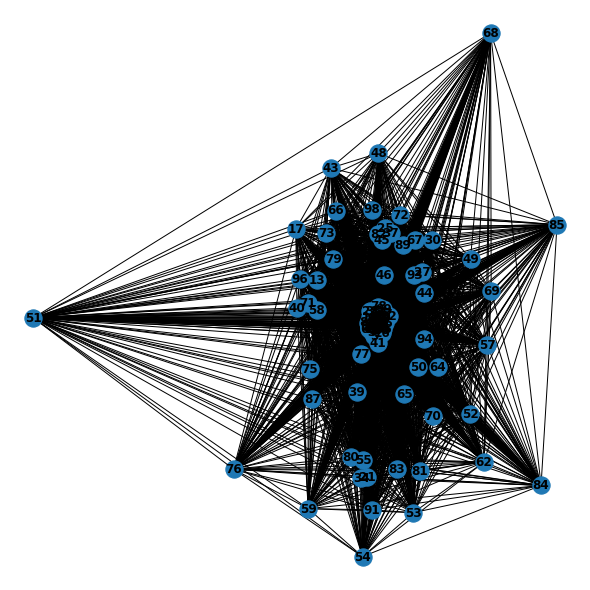

In [7]:
# Fully Connected Graph

plt.figure(1,figsize=(8,8))
nx.draw(fully_connected_graph, with_labels=True, font_weight='bold')
plt.show()

In [8]:
# Selecting only the highest weight edge per nodes

graph_1 = createGraph(len(subredditNames))

for node in range(len(subredditNames)-1):
    node_edge_wight = [(node,i,fully_connected_graph.edges[i,node]['weight']) for i in list(fully_connected_graph.adj[node]) if i >= node]
    u,v,w = max(node_edge_wight,key=itemgetter(2))
    graph_1.add_edge(u,v,weight=w)

print('Done')

Done


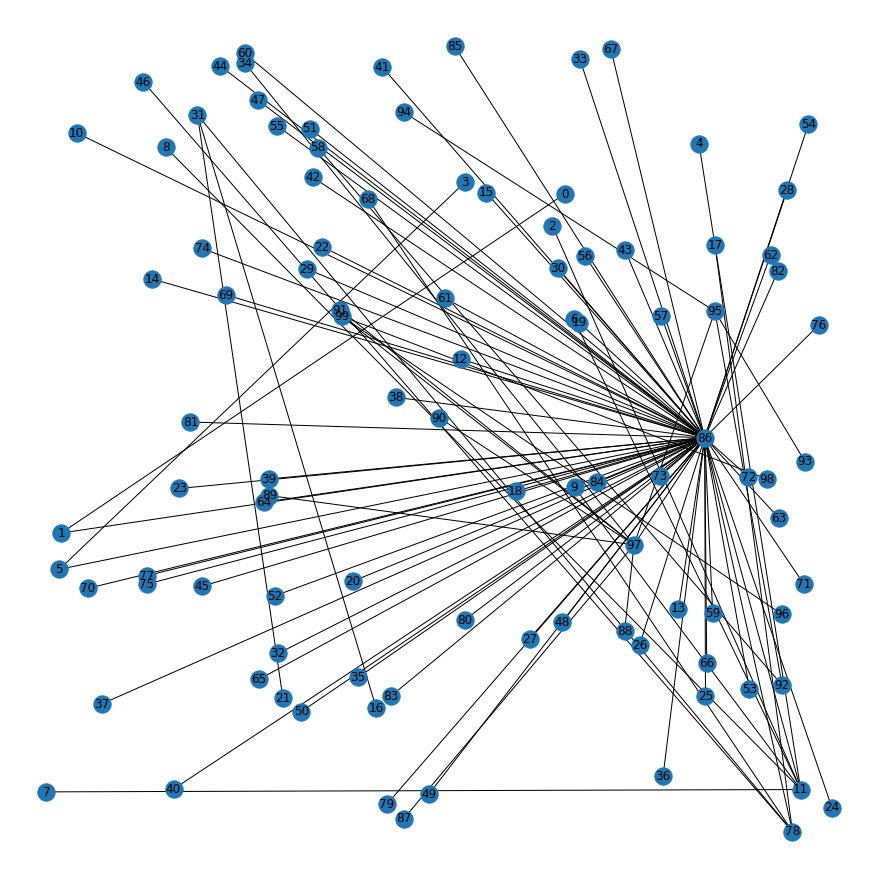

In [9]:
plt.figure(1,figsize=(12,12)) 
nx.draw_random(graph_1, with_labels=True)
plt.show()b

In [12]:
print(subredditNames[86])

politics


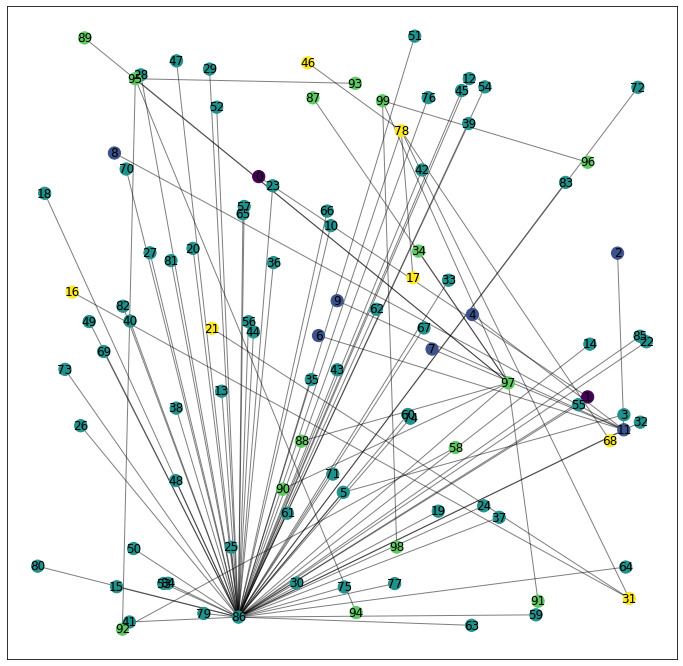

In [13]:
# using louvain on highest weight per node

partition = community_louvain.best_partition(graph_1,weight='weight')

# draw the graph

pos = nx.random_layout(graph_1)

# color the nodes according to their partition

cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
plt.figure(1,figsize=(12,12))
nx.draw_networkx_nodes(graph_1, pos, partition.keys(), node_size=150, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph_1, pos, alpha=0.5)
nx.draw_networkx_labels(graph_1, pos)
plt.show()

In [14]:
# List community for graph_1 using louvain

for i in list(set(partition.values())):
    new_partition = dict(filter(lambda elem: elem[1] == i,partition.items()))
    new_list = [subredditNames[key] for key in list(new_partition.keys())]
    print('Community # ',i," list: ",new_list)

Community #  0  list:  ['funny', 'AskReddit']
Community #  1  list:  ['gaming', 'Music', 'science', 'worldnews', 'videos', 'todayilearned', 'news']
Community #  2  list:  ['aww', 'pics', 'movies', 'Showerthoughts', 'EarthPorn', 'gifs', 'IAmA', 'Jokes', 'LifeProTips', 'PrequelMemes', 'books', 'mildlyinteresting', 'nottheonion', 'DIY', 'sports', '2meirl4meirl', 'space', 'gadgets', 'anime', 'Unexpected', 'YouShouldKnow', 'bestof', 'MadeMeSmile', 'pettyrevenge', 'WTF', 'cringepics', 'wholesomegifs', 'cringe', 'mildlyinfuriating', 'rage', 'leagueoflegends', 'pokemon', 'Games', 'DotA2', 'starcraft', 'skyrim', 'mindcrack', 'arresteddevelopment', 'gameofthrones', 'doctorwho', 'harrypotter', 'StarWars', 'DaftPunk', 'geek', 'AdviceAnimals', 'IdiotsInCars', 'circlejerk', 'facepalm', 'TrollXChromosomes', 'AnimalsBeingJerks', 'youtubehaiku', 'woahdude', 'PerfectTiming', 'itookapicture', 'AbandonedPorn', 'techsupportgore', 'askscience', 'explainlikeimfive', 'cats', 'corgi', 'food', 'lifehacks', 'Fru

In [15]:
# Each node have at most 2 edges

hist = []
graph_2 = createGraph(len(subredditNames))

for node in range(len(subredditNames)-1):
    node_edge_wight = [(node,i,fully_connected_graph.edges[i,node]['weight']) for i in list(fully_connected_graph.adj[node]) if i >= node and i not in hist]
    if (node_edge_wight):
        u,v,w = max(node_edge_wight,key=itemgetter(2))
        graph_2.add_edge(u,v,weight=w)
    hist.append(v)
    
print('Done')

Done


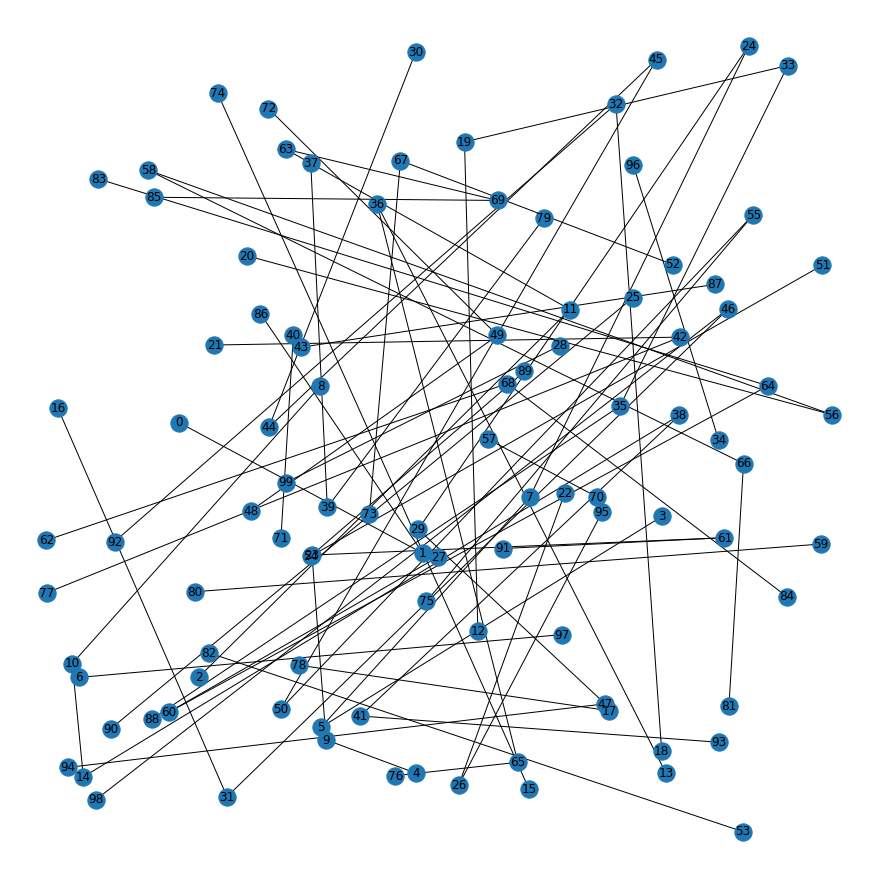

In [16]:
plt.figure(1,figsize=(12,12)) 
nx.draw_random(graph_2, with_labels=True)
plt.show()

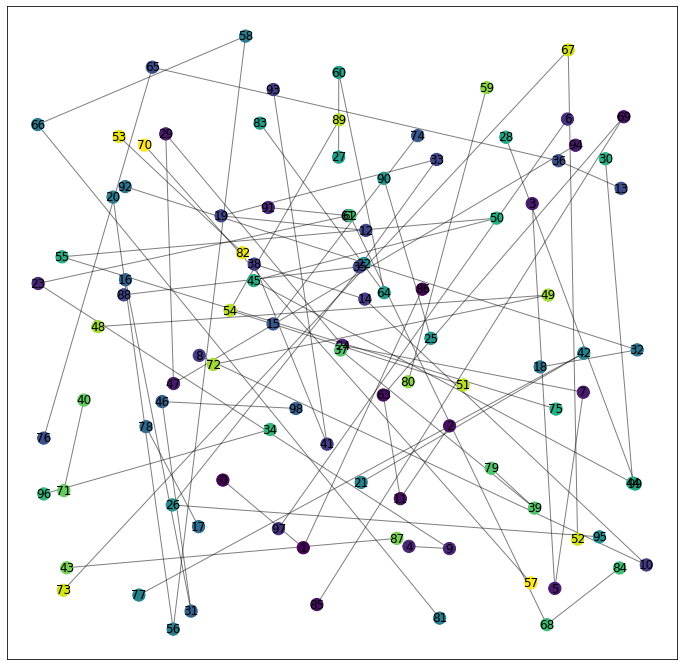

In [17]:
# using louvain on a graph such that each node have at most 2 edges

partition_2 = community_louvain.best_partition(graph_2,weight='weight')

# draw the graph

pos = nx.random_layout(graph_2)

# color the nodes according to their partition

cmap = cm.get_cmap('viridis', max(partition_2.values()) + 1)
plt.figure(1,figsize=(12,12))
nx.draw_networkx_nodes(graph_2, pos, partition_2.keys(), node_size=150, cmap=cmap, node_color=list(partition_2.values()))
nx.draw_networkx_edges(graph_2, pos, alpha=0.5)
nx.draw_networkx_labels(graph_2, pos)
plt.show()

In [18]:
# List community for graph_2 using louvain

for i in list(set(partition_2.values())):
    new_partition = dict(filter(lambda elem: elem[1] == i,partition_2.items()))
    new_list = [subredditNames[key] for key in list(new_partition.keys())]
    print('Community # ',i," list: ",new_list)

Community #  0  list:  ['funny', 'AskReddit', 'politics']
Community #  1  list:  ['gaming', 'news', 'facepalm', 'PerfectTiming', 'Random_Acts_Of_Amazon']
Community #  2  list:  ['aww', 'pics', 'worldnews', 'nottheonion', 'gadgets', 'Games', 'hockey']
Community #  3  list:  ['Music', 'todayilearned', 'mildlyinteresting', 'IdiotsInCars', 'MensRights']
Community #  4  list:  ['science', 'technology']
Community #  5  list:  ['videos', 'movies', 'gifs', 'WTF', 'cringe', 'soccer']
Community #  6  list:  ['Showerthoughts', 'LifeProTips', 'YouShouldKnow', 'bestof', 'atheism']
Community #  7  list:  ['EarthPorn', 'MadeMeSmile', 'AnimalsBeingJerks', 'corgi']
Community #  8  list:  ['IAmA', 'explainlikeimfive']
Community #  9  list:  ['dankmemes', 'memes', 'Minecraft', 'PewdiepieSubmissions']
Community #  10  list:  ['ComedyCemetery', 'teenagers']
Community #  11  list:  ['Jokes', 'Unexpected', 'nba']
Community #  12  list:  ['PrequelMemes', 'StarWars', 'hiphopheads', 'youtubehaiku', 'Fitness']
C

In [19]:
# Select 

weight_list = []
for (u, v, wt) in fully_connected_graph.edges.data('weight'):
    weight_list.append((u,v,wt))
    
weight_list.sort(key=lambda tup:tup[2], reverse=True)

graph_3 = createGraph(len(subredditNames))

left_node = []
right_node = []

for i in range(100):
    temp_list = [(u,v,w) for (u,v,w) in weight_list if u not in left_node and v not in right_node]
    if (temp_list):
        left,right,w = temp_list[0]
        graph_3.add_edge(left,right,weight=w)
        left_node.append(left)
        right_node.append(right)

print('Done')

Done


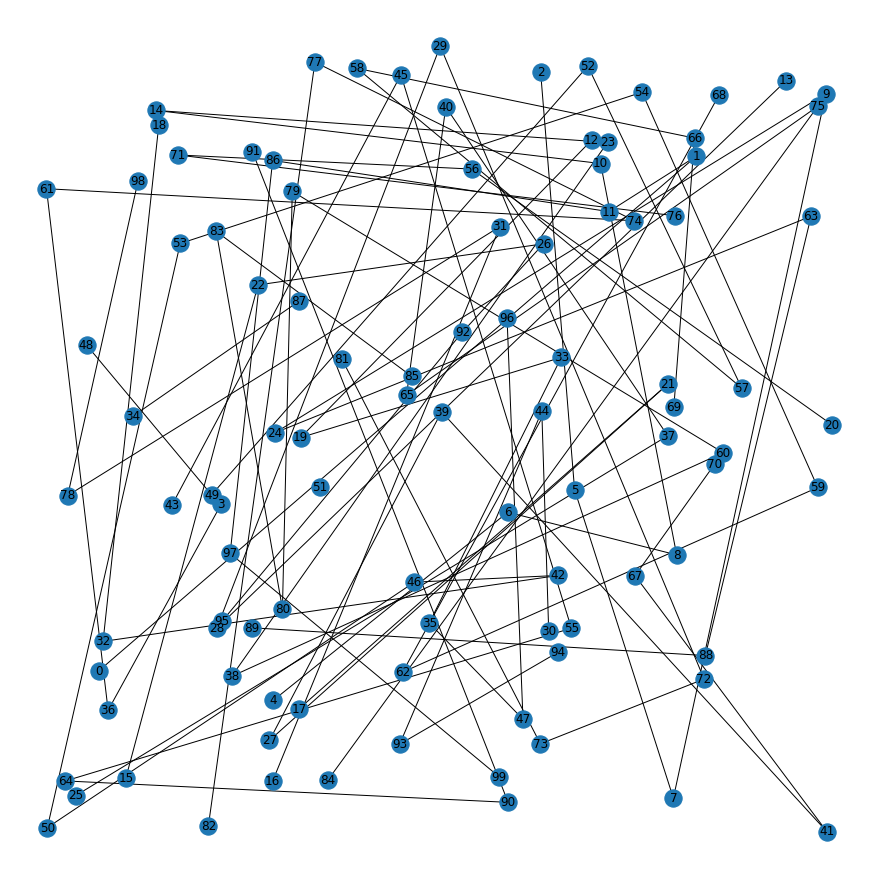

In [20]:
plt.figure(1,figsize=(12,12)) 
nx.draw_random(graph_3, with_labels=True)
plt.show()

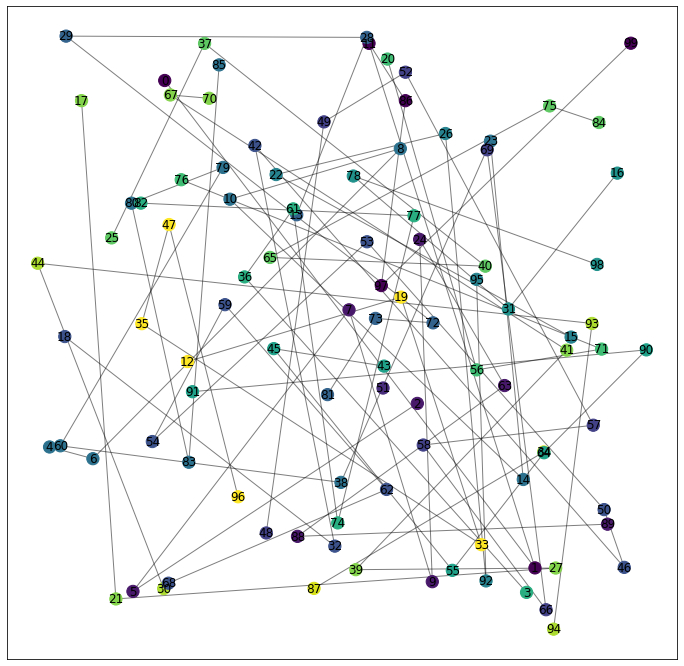

In [21]:
# using louvain on a graph such that each node have at most 2 edges

partition_3 = community_louvain.best_partition(graph_3,weight='weight')

# draw the graph

pos = nx.random_layout(graph_3)

# color the nodes according to their partition

cmap = cm.get_cmap('viridis', max(partition_3.values()) + 1)
plt.figure(1,figsize=(12,12))
nx.draw_networkx_nodes(graph_3, pos, partition_3.keys(), node_size=150, cmap=cmap, node_color=list(partition_3.values()))
nx.draw_networkx_edges(graph_3, pos, alpha=0.5)
nx.draw_networkx_labels(graph_3, pos)
plt.show()

In [22]:
# List community for graph_3 using louvain

for i in list(set(partition_3.values())):
    new_partition = dict(filter(lambda elem: elem[1] == i,partition_3.items()))
    new_list = [subredditNames[key] for key in list(new_partition.keys())]
    print('Community # ',i," list: ",new_list)

Community #  0  list:  ['funny', 'AskReddit', 'news', 'politics', 'technology', 'apple']
Community #  1  list:  ['gaming', 'pics', 'worldnews', 'todayilearned', 'nottheonion', 'facepalm', 'atheism', 'lgbt']
Community #  2  list:  ['mindcrack']
Community #  3  list:  ['DotA2', 'starcraft', 'arresteddevelopment', 'DaftPunk', 'hiphopheads', 'youtubehaiku', 'PerfectTiming']
Community #  4  list:  ['Jokes', 'Unexpected', 'mildlyinfuriating', 'Minecraft', 'skyrim', 'gameofthrones', 'doctorwho', 'geek', 'circlejerk', 'awwnime']
Community #  5  list:  ['EarthPorn', 'space', 'gadgets', 'techsupportgore', 'askscience', 'Fitness']
Community #  6  list:  ['Music', 'science', 'videos', 'movies', 'gifs', 'mildlyinteresting', 'WTF', 'AdviceAnimals', 'lifehacks', 'Frugal', 'loseit', 'Random_Acts_Of_Amazon']
Community #  7  list:  ['IAmA', 'books', 'sports', 'nba', 'nfl']
Community #  8  list:  ['dankmemes', 'memes', 'teenagers', 'PewdiepieSubmissions']
Community #  9  list:  ['rage', 'pokemon', 'harry

In [ ]:
from networkx.algorithms.community import kernighan_lin_bisection

c = list(kernighan_lin_bisection(G, partition=None, max_iter=37, weight='weight'))

In [ ]:
print(c)

In [ ]:
from operator import itemgetter
from networkx.algorithms.community import girvan_newman
import itertools
from networkx import edge_betweenness_centrality as betweenness

def heaviest(G):
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u, v)

def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)

k = 
comp = girvan_newman(G, most_valuable_edge=most_central_edge)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    print(tuple(sorted(c) for c in communities))  

In [ ]:
girvan_community = [0, 1, 2, 5, 6, 7, 9, 10, 12, 14, 19, 23, 24, 86], [3, 4, 8, 13, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99], [11, 51], [36], [38], [61, 63, 68, 84, 85, 97]

In [ ]:
for i in girvan_community:
    new_list = [subredditNames[key] for key in i]
    print("list: ",new_list)

In [ ]:
def lowest(G):
    u, v, w = min(G.edges(data='weight'), key=itemgetter(2))
    return (u, v, w)

u,v,w = lowest(G)
while (w < 100):
    G.remove_edge(u,v)
    u ,v,w = lowest(G)
    print(u,v)

In [ ]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()